# General Insights  

Let's visualize the dataset to see if there are some general (non-ML) insights we can get

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Zip code efficiency (net emissions/sqrt_ft) for multi-home units:

In [12]:
data = pd.read_csv('./data/data_cleaned.csv')
print(data['postal_code'].unique())

['11103' '10025' '10013' '10031' '10032' '10033' '10040' '10034' '10003'
 '10453' '10473' '10462' '11225' '11226' '11230' '11372' '10022' '10301'
 '10023' '10002' '10026' '10035' '10455' '11222' '11354' '11370' '10011'
 '11428' '11102' '11377' '10021' '10019' '10016' '10024' '11435' '11373'
 '10065' '11358' '11104' '11415' '10036' '10075' '10461' '10463' '10470'
 '10452' '11216' '10460' '10467' '11221' '10028' '10459' '11238' '11231'
 '11215' '11423' '10454' '11432' '11213' '11694' '11223' '10468' '11206'
 '11217' '10471' '11201' '10010' '10029' '11375' '11224' '10014' '10069'
 '11427' '10004' '10005' '10012' '10001' '10017' '10128' '10030' '11364'
 '11360' '11205' '11109' '11249' '10039' '10038' '11105' '11101' '11210'
 '11374' '11218' '10018' '11212' '10027' '11691' '10304' '10456' '11208'
 '10457' '10475' '11207' '11418' '10305' '10472' '11233' '10280' '11421'
 '11367' '11236' '10282' '11040' '11211' '10009' '10007' '11106'
 '11232-3165' '11368' '100128' '10458' '10037' '11209' '112

In [13]:
zip_code_adjustments = {
    '11232-3165':'11232',
    '104674512':'10467',
    '10013 ?':'10013',
    '10031-6032': '10031',
    '112211760':'11221',
    '114342300':'11434',
    '112126939':'11212',
    '112290523':'11229',
    '11385-6201':'11385'
    }

for key in zip_code_adjustments.keys():
    value = zip_code_adjustments[key]
    data['postal_code'] = data['postal_code'].replace(key, value)

Net emissions average per building

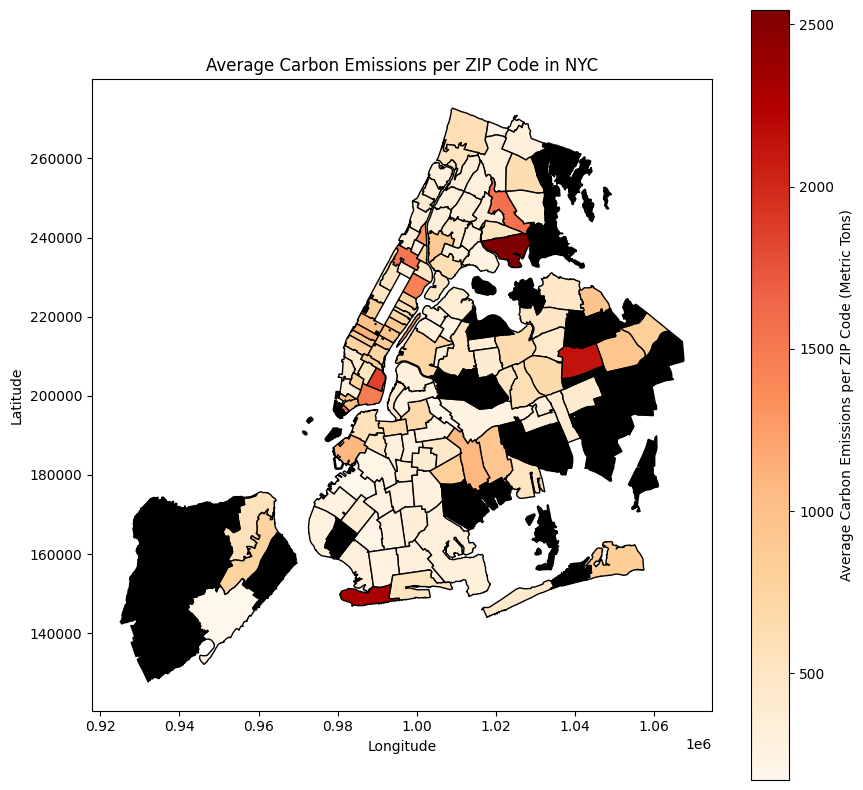

In [87]:

# Compute average emissions per ZIP code
avg_emissions_per_zip = data.groupby('postal_code')['net_emissions_metric_tons'].mean().reset_index()

# Load the shapefile
nyc_shape = gpd.read_file('./data/map_files/ZIP_CODE_040114.shp')

# Merge shapefile data with average emissions data
nyc_shape['ZIPCODE'] = nyc_shape['ZIPCODE'].astype(str)
avg_emissions_per_zip['postal_code'] = avg_emissions_per_zip['postal_code'].astype(str)
merged_data = nyc_shape.merge(avg_emissions_per_zip, left_on='ZIPCODE', right_on='postal_code')

# Calculate data points per ZIP code and identify those with fewer than 20 data points
data_points_per_zip = data.groupby('postal_code').size().reset_index(name='data_points')
avg_emissions_with_counts = avg_emissions_per_zip.merge(data_points_per_zip, on='postal_code')
insufficient_data_zips_20 = avg_emissions_with_counts[avg_emissions_with_counts['data_points'] < 20]['postal_code'].tolist()
merged_data['insufficient_data_20'] = merged_data['ZIPCODE'].isin(insufficient_data_zips_20)

# Plotting the data with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
merged_data[~merged_data['insufficient_data_20']].plot(column='net_emissions_metric_tons', ax=ax, legend=True,
                                                       legend_kwds={'label': "Average Carbon Emissions per ZIP Code (Metric Tons)"},
                                                       cmap='OrRd', edgecolor='black')
merged_data[merged_data['insufficient_data_20']].plot(ax=ax, color='black', edgecolor='black')
plt.title("Average Carbon Emissions per ZIP Code in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Now we want to see the efficiency of the buildings rather. We adjust for the gross area of the building and plot again.

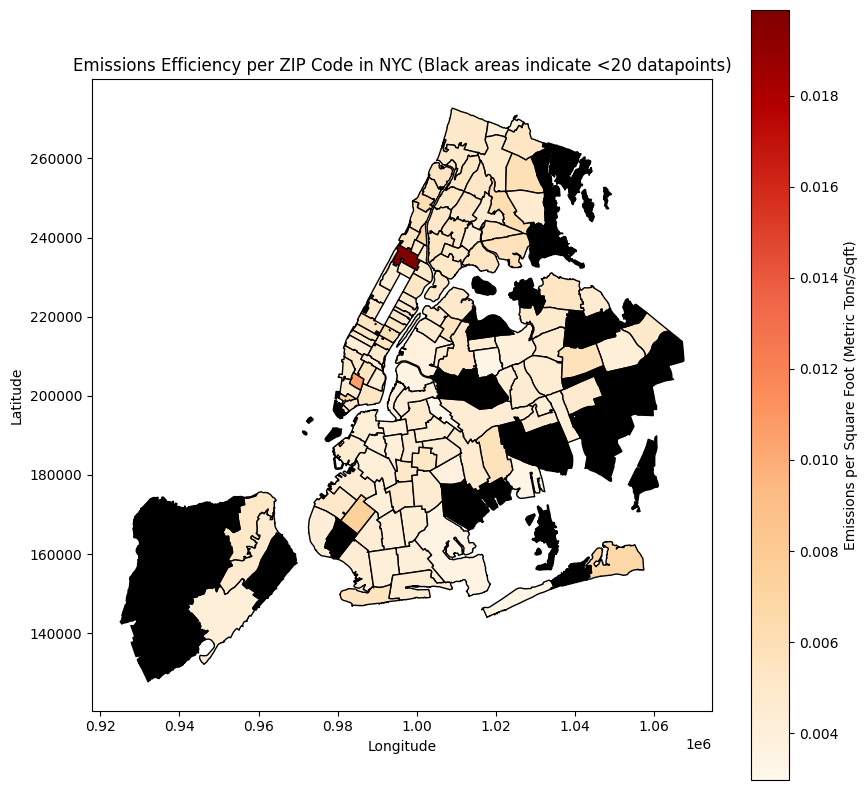

In [15]:
# Compute average emissions and total square footage per ZIP code
total_emissions_per_zip = data.groupby('postal_code')['net_emissions_metric_tons'].sum().reset_index()
total_sqft_per_zip = data.groupby('postal_code')['multifamily_housing_gross'].sum().reset_index()

# Merge the total emissions and total square footage data
emissions_sqft_data = pd.merge(total_emissions_per_zip, total_sqft_per_zip, on='postal_code')

# Compute emissions per square foot
emissions_sqft_data['emissions_per_sqft'] = emissions_sqft_data['net_emissions_metric_tons'] / emissions_sqft_data['multifamily_housing_gross']


# Merge this data with the shapefile
emissions_sqft_merged = nyc_shape.merge(emissions_sqft_data, left_on='ZIPCODE', right_on='postal_code')

# Calculate data points per ZIP code and identify those with fewer than 20 data points
data_points_per_zip = data.groupby('postal_code').size().reset_index(name='data_points')
avg_emissions_with_counts = emissions_sqft_data.merge(data_points_per_zip, on='postal_code')
insufficient_data_zips_20 = avg_emissions_with_counts[avg_emissions_with_counts['data_points'] < 20]['postal_code'].tolist()

# Mark ZIP codes with insufficient data for visualization
emissions_sqft_merged['insufficient_data_20'] = emissions_sqft_merged['ZIPCODE'].isin(insufficient_data_zips_20)

# Plotting the efficiency data with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
emissions_sqft_merged[~emissions_sqft_merged['insufficient_data_20']].plot(column='emissions_per_sqft', ax=ax, legend=True,
                                                                           legend_kwds={'label': "Emissions per Square Foot (Metric Tons/Sqft)"},
                                                                           cmap='OrRd', edgecolor='black')
emissions_sqft_merged[emissions_sqft_merged['insufficient_data_20']].plot(ax=ax, color='black', edgecolor='black')
plt.title("Emissions Efficiency per ZIP Code in NYC (Black areas indicate <20 datapoints)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [18]:
emissions_sqft_merged.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'postal_code', 'net_emissions_metric_tons',
       'multifamily_housing_gross', 'emissions_per_sqft',
       'insufficient_data_20'],
      dtype='object')

In [22]:
top_5_emission_densities = emissions_sqft_merged.sort_values(by='emissions_per_sqft', ascending=False).head(5)
print(top_5_emission_densities[['postal_code', 'emissions_per_sqft']])

    postal_code  emissions_per_sqft
41        10027            0.019881
182       10279            0.017021
121       11239            0.012883
93        10012            0.010589
78        11005            0.007946


### Comments
We see that once we adjust for the size of the buildings, we see most of the extremes filter out with a few exceptions. What we can take away is that while the average net emission per multi-home building does vary significantly in each zip code, once we adjust for the size of the residence, we can see the overal efficiency is fairly stable with only a few outliers.

# Feature importance

## 

In [75]:
df = pd.read_csv('./data/data_cleaned2.csv')

# zip_code_adjustments = {
#     '11232-3165':'11232',
#     '104674512':'10467',
#     '10013 ?':'10013',
#     '10031-6032': '10031',
#     '112211760':'11221',
#     '114342300':'11434',
#     '112126939':'11212',
#     '112290523':'11229',
#     '11385-6201':'11385'
#     }

# for key in zip_code_adjustments.keys():
#     value = zip_code_adjustments[key]
#     df['postal_code'] = df['postal_code'].replace(key, value)

df = pd.get_dummies(df, columns=['borough'], prefix='borough', drop_first=True)

print(list(df.columns))

borough_cols = list(df.filter(like='borough_').columns)
borough_cols = borough_cols[1:]


['property_id', 'year_ending', 'nyc_borough_block_and_lot', 'address_1', 'postal_code', 'primary_property_type_self', 'national_median_reference', 'largest_property_use_type_1', 'year_built', 'construction_status', 'number_of_buildings', 'occupancy', 'metered_areas_energy', 'national_median_energy_star', 'energy_star_certification_1', 'national_median_site_eui', 'national_median_source_eui', 'net_emissions_metric_tons', 'national_median_total_ghg', 'egrid_output_emissions_rate', 'multifamily_housing_gross', 'multifamily_housing_total', 'multifamily_housing_percent', 'multifamily_housing_percent_1', 'estimated_values_energy', 'estimated_values_water', 'alert_data_center_issue_with', 'alert_energy_meter_has_less', 'alert_energy_meter_has_gaps', 'alert_energy_meter_has', 'alert_energy_no_meters', 'alert_energy_meter_has_single', 'alert_water_meter_has_less', 'alert_property_has_no_uses', 'default_values', 'temporary_values', 'property_gfa_self_reported', 'property_gfa_calculated', 'last_m

In [82]:
numeric_features_to_keep = ["net_emissions_metric_tons",'year_built','number_of_buildings','occupancy','egrid_output_emissions_rate','multifamily_housing_gross','multifamily_housing_total',
                            'multifamily_housing_percent','national_median_site_eui','multifamily_housing_percent_1','property_gfa_self_reported','number_of_active_energy_meters','number_of_active_it_meters']

numeric_df = df[numeric_features_to_keep+borough_cols]
numeric_df

,net_emissions_metric_tons,year_built,number_of_buildings,occupancy,egrid_output_emissions_rate,multifamily_housing_gross,multifamily_housing_total,multifamily_housing_percent,national_median_site_eui,multifamily_housing_percent_1,property_gfa_self_reported,number_of_active_energy_meters,number_of_active_it_meters,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN IS
0,107.5,2010.0,1.0,100.0,84.5,25000.0,25.0,0.0,76.1,100.0,25000.0,8.0,0.0,False,False,True,False
1,398.6,1970.0,1.0,100.0,84.5,260780.0,208.0,0.0,45.5,100.0,261980.0,6.0,0.0,False,True,False,False
2,1323.0,1943.0,1.0,100.0,84.5,324378.0,258.0,0.0,87.1,100.0,333342.0,3.0,0.0,False,True,False,False
3,483.4,1941.0,1.0,100.0,84.5,72662.0,96.0,0.0,96.0,100.0,72662.0,11.0,0.0,False,True,False,False
4,544.8,1982.0,1.0,100.0,84.5,99110.0,58.0,0.0,98.2,100.0,99110.0,11.0,0.0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17805,198.5,1931.0,1.0,100.0,73.8,38199.0,40.0,0.0,95.9,90.0,38199.0,4.0,0.0,True,False,False,False
17806,204.6,1927.0,1.0,100.0,73.8,38736.0,46.0,0.0,81.8,90.0,38736.0,4.0,0.0,True,False,False,False
17807,135.8,1924.0,1.0,100.0,73.8,35824.0,46.0,0.0,82.7,90.0,35824.0,4.0,0.0,True,False,False,False
17808,313.5,1926.0,1.0,100.0,73.8,47130.0,56.0,0.0,85.9,90.0,49930.0,7.0,0.0,True,False,False,False


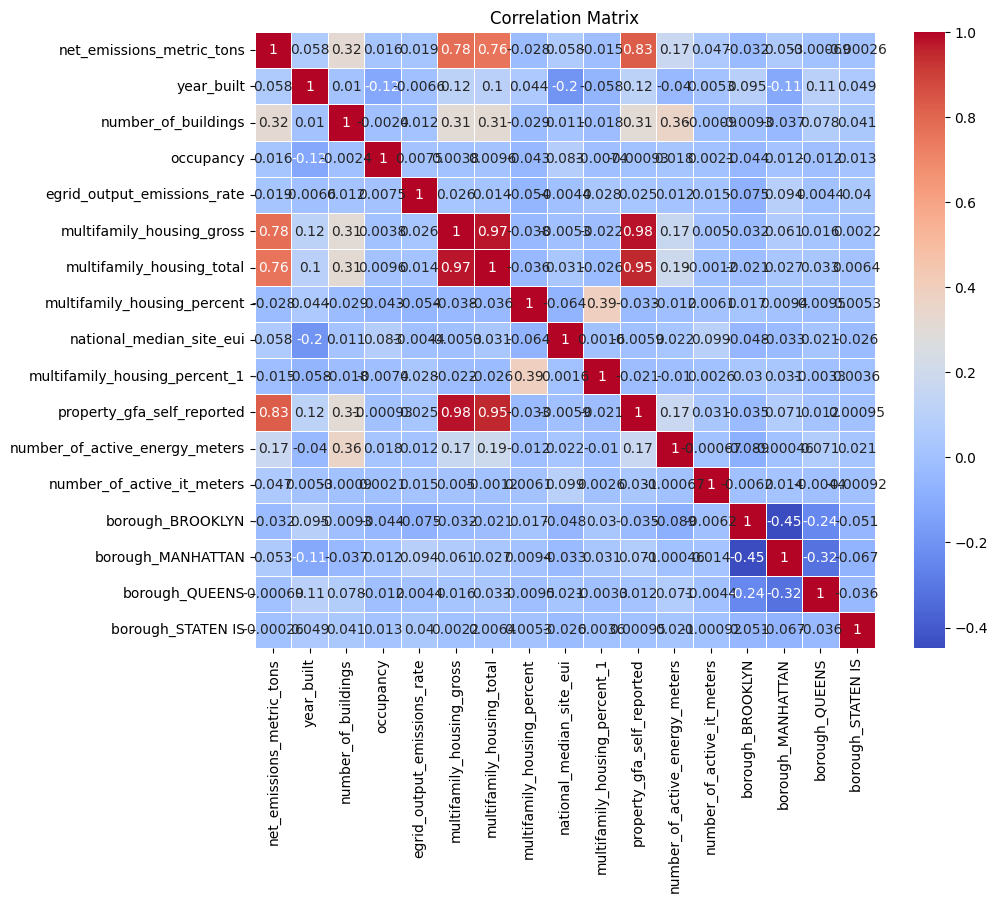

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix with colors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

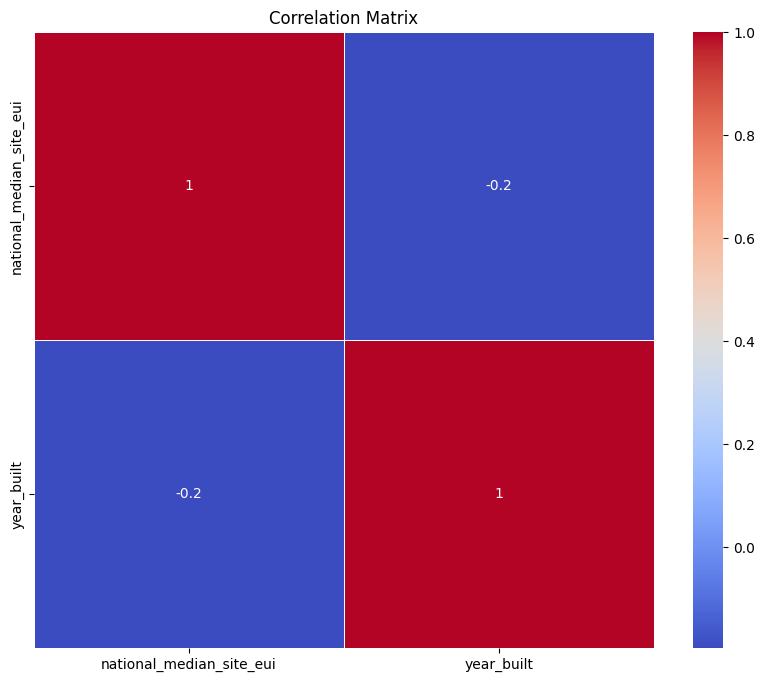

In [85]:
features = ['national_median_site_eui','year_built',]


import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
correlation_matrix = df[features].corr()

# Create a heatmap of the correlation matrix with colors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

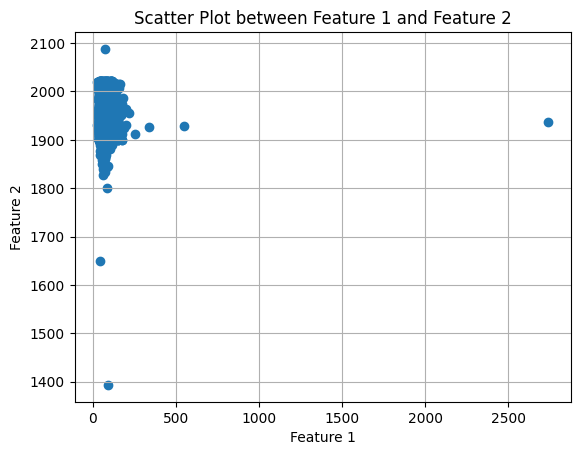

In [86]:
# Scatter plot
plt.scatter(df['national_median_site_eui'], df['year_built'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot between Feature 1 and Feature 2')
plt.grid(True)  # Optionally, you can add grid lines
plt.show()